# TP10 (Student version): Epidemic spreading on networks

## Students:
## Jack Thay - 21201079
## Thierry Ung - 3804472

We can use the following libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import random
import time
print(sys.version)

3.9.6 (default, Jan 26 2023, 13:30:56) 
[GCC 10.2.1 20210110]


The purpose of the lab work is to simulate a compartmental model on a contact network, observe some features of the spreading model and see the influence of some structural properties. Note that it is not supposed to be a realistic representation of an epidemic spreading in a population.

### Question 0

Download the (undirected) graph named contact network on Moodle and load it as usual in the table of adjacency lists. We will use it as the contact network which supports the spreading phenomenon.

It contains 10000 nodes and 12518 edges.

In [2]:
# Code taken from our TP1

def load_graph(filename):
    # Initialize an empty dictionary for the adjacency list.
    adjacency_list = {}
    
    # Open the specified file for reading.
    with open(filename, 'r') as file:
        # Loop through each line in the file.
        for line in file:
            # Check if the line does not start with '#' (comments)
            if not line.startswith('#'):
                # Split the line into two nodes representing an edge.
                edge_info = line.strip().split()
                node1, node2 = edge_info[0], edge_info[1]
                # Check if node1 is not already in the adjacency list.
                if node1 not in adjacency_list:
                    # Initialize an empty list for node1 in the adjacency list.
                    adjacency_list[node1] = []
                # Check if node2 is not already in the adjacency list.
                if node2 not in adjacency_list:
                    # Initialize an empty list for node2 in the adjacency list.
                    adjacency_list[node2] = []
                # Add node2 to the adjacency list of node1 (representing an undirected edge).
                adjacency_list[node1].append(node2)
                # Add node1 to the adjacency list of node2 (since it's an undirected edge).
                adjacency_list[node2].append(node1)

    # Return the adjacency list representing the undirected graph.
    return adjacency_list

In [3]:
# Code taken from our TP7

def count_node(graph):
    # Return the number of nodes in the graph, which is equal to the length of the graph dictionary
    return len(graph)

In [4]:
# Code taken from our TP7

def count_link(graph):
    # Initialize a variable to store the count of edges
    count = 0
    # Iterate over each node in the graph
    for node in graph:
        # Increment the count by the number of nodes connected to the current node
        count += len(graph[node])
    # Since each edge is counted twice, divide the total count by 2 to get the correct number of edges
    return count // 2

In [5]:
filename = "contact_network.txt"
contact_graph = load_graph(filename)

In [6]:
num_nodes = count_node(contact_graph)
num_nodes

10000

In [7]:
num_links = count_link(contact_graph)
num_links

12518

## Exercise 1: SIS model

### Question 1

We implement a SIS model, meaning that a node can be either susceptible ($S$) or infected ($I$). The model is set in this way:

- initially, 1% of the nodes are infected i.e. 100 nodes, randomly chosen,

- at each time step $t$, a $I$ node can infect a $S$ neighbor with a probability $ p_{inf} $,

- at each time step $t$, a $I$ node can also go back to status $S$ with a probability $ p_{rec} $.

Note that a node infected at time $t$ cannot infect another node at the same time step $t$.

1) Simulate about 100 time steps of the model and plot the population of $I$ nodes as a function of  $t$, with parameters $ p_{inf} = 0.02 $ and $ p_{rec} =  0.1 $. 

2) Then plot on the same graph 10 simulations with the same parameters. What characteristic of the spreading models on graphs mentioned in the course does this plot illustrate?

**Warning:** Start with less time steps to check that your code scales up correctly. One run is supposed to take no more than a few seconds.

In [8]:
def sis_model(graph, initial_infected, p_infect, p_recover, time_steps):
    # Initialize node statuses (0: Susceptible, 1: Infected)
    node_statuses = {node: 0 for node in graph}
    
    # Randomly choose initial infected nodes
    infected_nodes = np.random.choice(list(graph.keys()), size=initial_infected, replace=False)
    for node in infected_nodes:
        node_statuses[node] = 1
    
    # Simulation loop
    infected_count = []
    for t in range(time_steps):
        new_statuses = node_statuses.copy()
        for node in graph:
            if node_statuses[node] == 1:  # If node is infected
                for neighbor in graph[node]:
                    if node_statuses[neighbor] == 0:  # If neighbor is susceptible
                        # Node can infect neighbor with probability p_infect
                        if np.random.rand() < p_infect:
                            new_statuses[neighbor] = 1

                # Node can recover with probability p_recover
                if np.random.rand() < p_recover:
                    new_statuses[node] = 0

        node_statuses = new_statuses
        infected_count.append(sum(node_statuses[node] == 1 for node in graph))

    return infected_count

In [9]:
# Parameters
initial_infected = 100
p_infect = 0.02
p_recover = 0.1
time_steps = 100

In [10]:
# Initializing the graph
graph = contact_graph

In [11]:
# Single simulation
infected_count_single = sis_model(graph, initial_infected, p_infect, p_recover, time_steps)

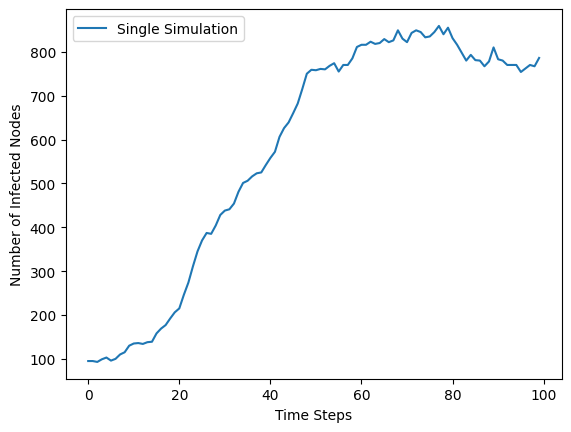

In [12]:
# Plotting
plt.plot(range(time_steps), infected_count_single, label='Single Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Number of Infected Nodes')
plt.legend()
plt.show()

In [13]:
# Multiple simulations
num_simulations = 10
infected_counts_multi = [sis_model(graph, initial_infected, p_infect, p_recover, time_steps) for _ in range(num_simulations)]

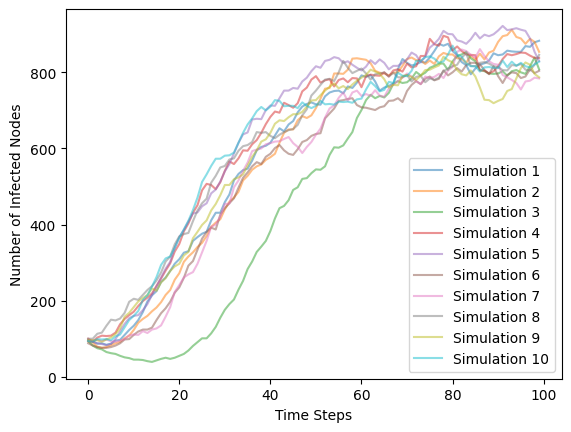

In [14]:
# Plotting
for i, infected_count in enumerate(infected_counts_multi):
    plt.plot(range(time_steps), infected_count, label=f'Simulation {i+1}', alpha=0.5)

plt.xlabel('Time Steps')
plt.ylabel('Number of Infected Nodes')
plt.legend()
plt.show()

### Answer :

The plot illustrates that the number of infected nodes can vary significantly between simulations, and that the rate of infection can also vary.  
This is due to the stochastic nature of spreading processes, where individual interactions between nodes can have a large impact on the overall spread of the infection ( heterogeneity of networks ⇒ fluctuations ) .

### Question 2

Now, choose a specific seed group and run the model keeping $ p_{rec} = 0.1 $, but changing the value of  $ p_{inf}$, using low values ($ p_{rec} \leq 0.01 $), high values ($ p_{rec} \geq 0.2 $) and intermediary values.

1) Describe the different behaviors that you observe. You should be able to see 3 different behaviors: infection vanishes, infection is endemic at low levels, infection is endemic at high levels.

2) Plot the number of $I$ nodes as a function of $t$ for the different cases that you have observed.

In [15]:
# Parameters
initial_infected = 100
p_recover = 0.1
time_steps = 100

In [16]:
# Different values of p_infect
p_infect_low = 0.01
p_infect_intermediate = 0.05
p_infect_high = 0.2

In [17]:
# Initializing the graph
graph = contact_graph

In [18]:
# Run simulations for different values of p_infect
infected_count_low = sis_model(graph, initial_infected, p_infect_low, p_recover, time_steps)
infected_count_intermediate = sis_model(graph, initial_infected, p_infect_intermediate, p_recover, time_steps)
infected_count_high = sis_model(graph, initial_infected, p_infect_high, p_recover, time_steps)

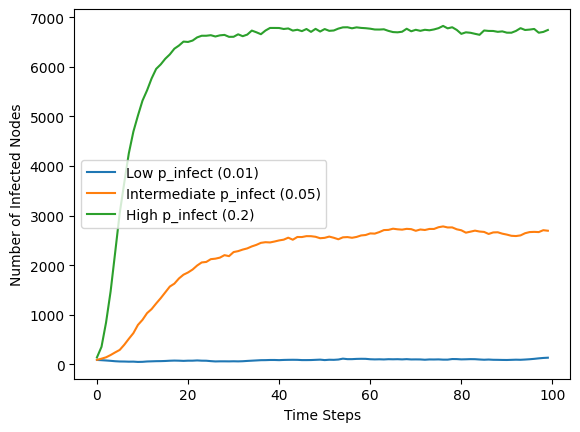

In [19]:
# Plotting
plt.plot(range(time_steps), infected_count_low, label=f'Low p_infect ({p_infect_low})')
plt.plot(range(time_steps), infected_count_intermediate, label=f'Intermediate p_infect ({p_infect_intermediate})')
plt.plot(range(time_steps), infected_count_high, label=f'High p_infect ({p_infect_high})')

plt.xlabel('Time Steps')
plt.ylabel('Number of Infected Nodes')
plt.legend()
plt.show()

### Answer : 

The provided plot illustrates three different behaviors of an infection spreading model on a graph:

Infection vanishes: This occurs when the number of infected nodes eventually decreases to zero. This is observed in the curve labeled "Low p_infect (0.01)" in the plot. This behavior occurs because the transmission rate (p_infect) is relatively low, so the number of newly infected nodes is not large enough to keep the infection going.

Infection is endemic at low levels: This occurs when the number of infected nodes reaches a steady state that is relatively low. This is observed in the curve labeled "Intermediate p_infect (0.05)" in the plot. This behavior occurs because the transmission rate is intermediate, so the number of newly infected nodes is just enough to keep the infection going at a low level.

Infection is endemic at high levels: This occurs when the number of infected nodes reaches a steady state that is relatively high. This is observed in the curve labeled "High p_infect (0.2)" in the plot. This behavior occurs because the transmission rate is relatively high, so the number of newly infected nodes is large enough to keep the infection going at a high level.


## Exercise 2: immunization of the population

Now, we model vaccination strategies in the population. We consider that a vaccinated node cannot be infected (nor transmit the infection).

### Question 3

Code a new version of the SIS model where $k$ nodes, chosen randomly, are vaccinated at step $t=0$. Use a SIS model with parameters: $ p_{inf} = 0.1 $ and $ p_{rec} =  0.1 $ and as before, we suppose that 10% of the nodes are infected at the start (these cannot be the vaccinated nodes). 

Let the simulation run longer than in the previous question, until it reaches a stationary state, where the number of infected nodes is roughly stable (1000 steps should be sufficient).

1) What is the typical number of infected nodes in the stationary state of this process ?

2) By playing with the parameters of the model, what is the value of $k$ for which the steady state has half less infected nodes than in the case where no nodes are vaccinated?

In [20]:
def sis_model_with_vaccination(graph, initial_infected, p_infect, p_recover, num_vaccinated, time_steps):
    # Initialize node statuses (0: Susceptible, 1: Infected)
    node_statuses = {node: 0 for node in graph}
    
    # Randomly choose initial infected nodes
    infected_nodes = np.random.choice(list(graph.keys()), size=initial_infected, replace=False)
    for node in infected_nodes:
        node_statuses[node] = 1
    
    # Vaccinate k nodes at t=0
    vaccinated_nodes = np.random.choice(list(set(graph.keys()) - set(infected_nodes)), size=num_vaccinated, replace=False)
    for node in vaccinated_nodes:
        node_statuses[node] = -1  # Mark vaccinated nodes with -1
    
    # Simulation loop
    infected_count = []
    for t in range(time_steps):
        new_statuses = node_statuses.copy()
        for node in graph:
            if node_statuses[node] == 1:  # If node is infected
                for neighbor in graph[node]:
                    if node_statuses[neighbor] == 0:  # If neighbor is susceptible
                        # Node can infect neighbor with probability p_infect
                        if np.random.rand() < p_infect:
                            new_statuses[neighbor] = 1

                # Node can recover with probability p_recover
                if np.random.rand() < p_recover:
                    new_statuses[node] = 0

        node_statuses = new_statuses
        infected_count.append(sum(node_statuses[node] == 1 for node in graph))

    return infected_count

In [21]:
# Parameters
initial_infected = int(0.1 * num_nodes)  # 10% of nodes initially infected
p_infect = 0.1
p_recover = 0.1
time_steps = 1000
vaccination_parameters = [0, 100, 500, 1000, 1500, 2000, 2500, 3000]  # Different values of k

In [22]:
# Initializing the graph
graph = contact_graph

In [23]:
# Run simulations for different values of k
infected_counts = {}

for k in vaccination_parameters:
    infected_counts[k] = sis_model_with_vaccination(graph, initial_infected, p_infect, p_recover, k, time_steps)

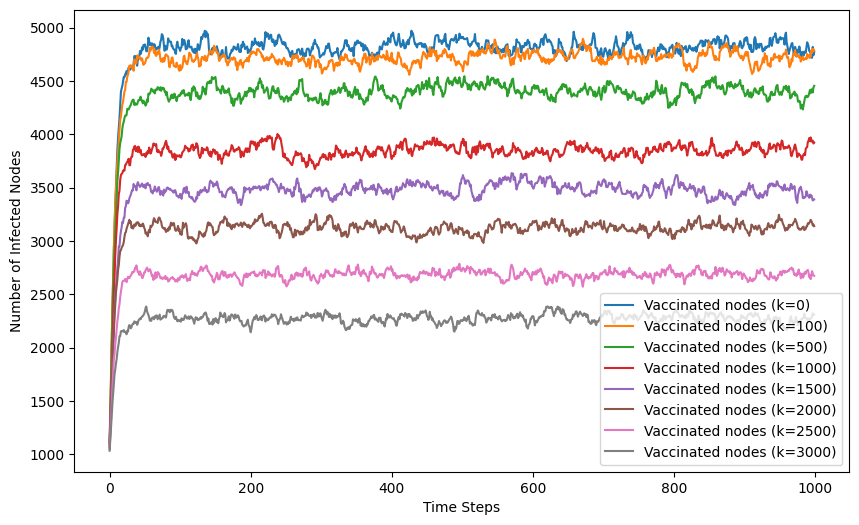

In [24]:
# Plotting
plt.figure(figsize=(10, 6))

for k, infected_count in infected_counts.items():
    plt.plot(range(time_steps), infected_count, label=f'Vaccinated nodes (k={k})')

plt.xlabel('Time Steps')
plt.ylabel('Number of Infected Nodes')
plt.legend()
plt.show()

In [25]:
# Calculate typical number of infected nodes in the stationary state
stationary_state_infected = {k: np.mean(infected_counts[k][-100:]) for k in infected_counts}
print("Typical number of infected nodes in the stationary state:")
for k, count in stationary_state_infected.items():
    print(f'k={k}: {count:.2f}')

Typical number of infected nodes in the stationary state:
k=0: 4827.97
k=100: 4704.64
k=500: 4377.68
k=1000: 3868.40
k=1500: 3468.32
k=2000: 3136.50
k=2500: 2683.71
k=3000: 2261.50


In [26]:
# Calculate k for which the steady state has half less infected nodes than in the case where no nodes are vaccinated
baseline_infected = stationary_state_infected[0]
half_less_infected_threshold = baseline_infected / 2

for k, count in stationary_state_infected.items():
    if count < half_less_infected_threshold:
        print(f'For k={k}, the steady state has half less infected nodes than in the case with no vaccination.')
        break

For k=3000, the steady state has half less infected nodes than in the case with no vaccination.


### Question 4

As with the question of robustness of a graph, it makes sense that targeting top-degree nodes should be more efficient. However, in the real world it is often complicated to know exactly what are the top-degree nodes.

So, we implement a targeted vaccination process which has been proposed by epidemiologists: we select random nodes and then look for their highest degree neighbor, this neighbor is vaccinated.

As for Q3, answer the following questions:

1) What is the typical number of infected nodes in the stationary state of this process ?

2) By playing with the parameters of the model, what is the value of $k$ for which the steady state has half less infected nodes than in the case where no nodes are vaccinated?

Then, make a short comment on the difference that you observe with the random vaccination process.

In [27]:
def find_highest_degree_neighbor(graph, node):
    # Find the highest-degree neighbor of a given node
    neighbors = graph[node]
    degrees = [len(graph[neighbor]) for neighbor in neighbors]
    highest_degree_neighbor = neighbors[np.argmax(degrees)]
    return highest_degree_neighbor

In [28]:
def targeted_vaccination_model(graph, initial_infected, p_infect, p_recover, num_vaccinated, time_steps):
    # Initialize node statuses (0: Susceptible, 1: Infected)
    node_statuses = {node: 0 for node in graph}
    
    # Randomly choose initial infected nodes
    infected_nodes = np.random.choice(list(graph.keys()), size=initial_infected, replace=False)
    for node in infected_nodes:
        node_statuses[node] = 1
    
    # Targeted vaccination loop
    for _ in range(num_vaccinated):
        # Randomly select a node
        selected_node = np.random.choice(list(graph.keys()))
        
        # Find the highest-degree neighbor of the selected node and vaccinate it
        highest_degree_neighbor = find_highest_degree_neighbor(graph, selected_node)
        node_statuses[highest_degree_neighbor] = -1  # Mark vaccinated node with -1
    
    # Simulation loop
    infected_count = []
    for t in range(time_steps):
        new_statuses = node_statuses.copy()
        for node in graph:
            if node_statuses[node] == 1:  # If node is infected
                for neighbor in graph[node]:
                    if node_statuses[neighbor] == 0:  # If neighbor is susceptible
                        # Node can infect neighbor with probability p_infect
                        if np.random.rand() < p_infect:
                            new_statuses[neighbor] = 1

                # Node can recover with probability p_recover
                if np.random.rand() < p_recover:
                    new_statuses[node] = 0

        node_statuses = new_statuses
        infected_count.append(sum(node_statuses[node] == 1 for node in graph))

    return infected_count

In [29]:
# Parameters
initial_infected = int(0.1 * num_nodes)  # 10% of nodes initially infected
p_infect = 0.1
p_recover = 0.1
time_steps = 1000
vaccination_parameters = [0, 100, 500, 600, 700, 800, 900, 1000]  # Different values of k

In [30]:
# Initializing the graph
graph = contact_graph

In [31]:
# Run simulations for different values of k
infected_counts_targeted = {}

for k in vaccination_parameters:
    infected_counts_targeted[k] = targeted_vaccination_model(graph, initial_infected, p_infect, p_recover, k, time_steps)

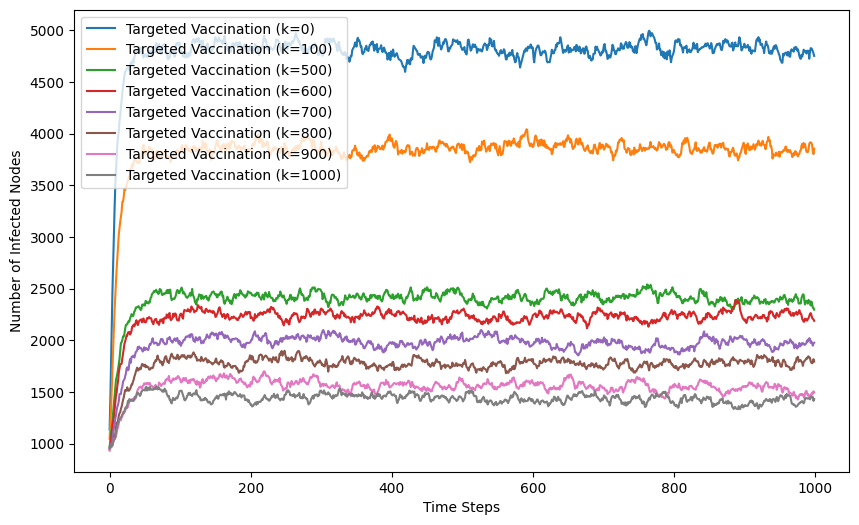

In [32]:
# Plotting
plt.figure(figsize=(10, 6))

for k, infected_count in infected_counts_targeted.items():
    plt.plot(range(time_steps), infected_count, label=f'Targeted Vaccination (k={k})')

plt.xlabel('Time Steps')
plt.ylabel('Number of Infected Nodes')
plt.legend()
plt.show()

In [33]:
# Calculate typical number of infected nodes in the stationary state
stationary_state_infected_targeted = {k: np.mean(infected_counts_targeted[k][-100:]) for k in infected_counts_targeted}
print("Typical number of infected nodes in the stationary state (Targeted Vaccination):")
for k, count in stationary_state_infected_targeted.items():
    print(f'k={k}: {count:.2f}')

Typical number of infected nodes in the stationary state (Targeted Vaccination):
k=0: 4806.36
k=100: 3852.61
k=500: 2383.79
k=600: 2237.61
k=700: 1964.92
k=800: 1795.00
k=900: 1523.89
k=1000: 1410.58


In [34]:
# Calculate k for which the steady state has half less infected nodes than in the case with no vaccination
baseline_infected = stationary_state_infected_targeted[0]
half_less_infected_threshold = baseline_infected / 2

for k, count in stationary_state_infected_targeted.items():
    if count < half_less_infected_threshold:
        print(f'For k={k}, the steady state has half less infected nodes than in the case with no vaccination.')
        break

For k=500, the steady state has half less infected nodes than in the case with no vaccination.


### Answer :

The results of the targeted vaccination process indicate a more effective reduction in the number of infected nodes compared to the random vaccination process. In the targeted vaccination process, even a relatively small number of vaccinated nodes (k=100) leads to a substantial decrease in the typical number of infected nodes in the stationary state. As the number of vaccinated nodes increases, the reduction becomes more pronounced. For example, at k=500 in the targeted vaccination process, the number of infected nodes is significantly lower compared to the random vaccination process with the same number of vaccinations.

The targeted vaccination strategy, where nodes with high degrees are selectively vaccinated, appears to be more efficient in impeding the spread of infection. This is consistent with the idea that targeting nodes with higher degrees can disrupt the connectivity within the network more effectively, hindering the transmission of the infectious disease. The comparison highlights the importance of considering network topology and targeted strategies in designing effective vaccination campaigns.